# Введение в стохастические методы

## Постановка задачи

$$
\min_x \sum_{i=1}^N f_i(x)
$$

- Целевая функция - сумма конечного числа функций
- $N$ может быть очень большим

### Особенности задачи

- Точное вычисление градиента занимает очень много времени
- Высокая точность решения обычно не требуется
- Допустимо введение случайности

### Градиентный спуск

$$
x_{k+1} = x_{k} - \alpha_k \sum_{i=1}^N f_i'(x_k)
$$
- $\alpha_k$ - малый шаг

## SGD

$$
x_{k+1} = x_k - \alpha_k \sum_{i \in \mathcal{I}} f'_i(x_k)
$$

- $\alpha_k = (1 - \beta)\alpha_0 + \beta \alpha_{s}$, $\beta = \frac{k}{\tau}$

Сходимость

- Для выпуклых функций $\mathcal{O}(1 / \sqrt{k})$
- Для сильно выпуклых функций $\mathcal{O}(1 / k)$

### Nesterov momentum

$$
\begin{align*}
& h_k = \beta h_{k-1} - \alpha_k \sum_{i\in \mathcal{I}} f'_i(x_k + \alpha_k h_k)\\
& x_{k+1} = x_k + h_k
\end{align*}
$$

- Не приводит к ускорению!
- Почему?

## Adagrad

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = r + g_k \cdot g_k\\
& h_k = -\frac{\varepsilon}{\delta + \sqrt{r}} \cdot g_k\\
& x_{k+1} = x_k + h_k
\end{align*}

- Диагональное шкалирование градиента
- Учёт **всей** предыдущей истории для вычисления следующей точки
- Не улучшает теоретические оценки сходимости

## Adam

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = \rho_2r + (1 - \rho_2) g_k \cdot g_k\\
& s = \rho_1 s + (1 - \rho_1) g_k\\
& \hat{s} = \frac{s}{1 - \rho_1^k}\\
& \hat{r} = \frac{r}{1 - \rho_2^k}\\
& h_k = -\frac{\varepsilon \hat{s}}{\delta + \sqrt{\hat{r}}} \\
& x_{k+1} = x_k + h_k
\end{align*}

## Приложения

- Всё, что связано с нейросетями
    - Компьютерное зрение
    - Обучение с подкреплением
    - GAN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    current_conv = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        current_conv.append(loss)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return current_conv

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
#                                            transforms.Normalize((0.1307,), (0.3081,))
                                           ])),
                            batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([
                                       transforms.ToTensor(),
#                                        transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                batch_size=16, shuffle=True)

In [5]:
epochs = 5
log_interval = 100
lr = 1e-3
momentum = 0.9

In [14]:
models = {
    "SGD": Net(),
    "SGD momentum": Net(),
    "Adam": Net(),
    "Adagrad": Net()
}

optimizers = {
    "SGD": optim.SGD(models["SGD"].parameters(), lr=lr),
    "SGD momentum": optim.SGD(models["SGD momentum"].parameters(), lr=lr, momentum=momentum),
    "Adam": optim.Adam(models["Adam"].parameters(), lr=lr),
    "Adagrad": optim.Adagrad(models["Adagrad"].parameters(), lr=lr)
}
conv = {opt_name: [] for opt_name in optimizers}
for opt in optimizers:
    print(opt)
    for epoch in range(1, epochs + 1):
        cur_conv = train(models[opt], train_loader, optimizers[opt], epoch, log_interval)
        conv[opt] = conv[opt] + cur_conv
#         display.clear_output(wait=True)
#         plt.plot(conv)
#     #     plt.yscale("log")
#         plt.show()
        test(models[opt], test_loader)

Adagrad
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307491
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.009911
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.644359
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.406306
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.167349
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.217354

Test set: Average loss: 0.0494, Accuracy: 8276/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.109717
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.982835
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.069785
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.053075
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.963383
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.843664

Test set: Average loss: 0.0354, Accuracy: 8634/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.091188
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.808560
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.989514
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.869209
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.839994
Train Epoch: 3 [50000/60000 (83%)]	

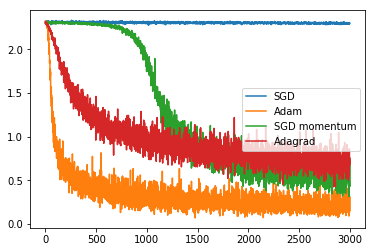

In [15]:
for opt_name in conv:
    plt.plot(conv[opt_name], label=opt_name)
plt.legend()

## Другие методы

- Для PyTorch много методов собраны в репозитории https://github.com/jettify/pytorch-optimizer 
- Для них нет хорошо разработанной теории, но они эффективны на практике
- Любая работающая эвристика с разумной мотивацией подходит!

## Покоординатный спуск и методы понижения дисперсии

In [109]:
from matplotlib import pyplot as plt
import time 

m, n = 1000, 10
torch.set_default_dtype(torch.float)
A = torch.randn(m, n)
x_true = torch.randn(n)
b = A @ x_true + 0.01 * torch.randn(m)
batch_size = 10
data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(A, b), batch_size=batch_size, shuffle=True)

In [110]:
x = torch.randn(n)
x_sgd = x.clone().requires_grad_(True)
def f(A, x):
    return A @ x

opt = torch.optim.SGD([x_sgd], lr=1e-3)
def l2_loss(x, y):
    return (x - y) @ (x - y)  / 2.

n_epoch = 10

def sgd_wrap():
    st = time.time()
    conv_sgd = []
    conv_sgd.append(l2_loss(b, f(A, x_sgd).view(-1)))
    for i in range(n_epoch):
        for a, y in data_loader:
            opt.zero_grad()
            loss = l2_loss(y, f(a, x_sgd).view(-1))
            loss.backward()
            opt.step()
            conv_sgd.append(l2_loss(y, f(a, x_sgd).view(-1)))
    print('Time SGD: {}'.format(time.time() - st))
    return conv_sgd

conv_sgd = sgd_wrap()

Time SGD: 0.607553243637085


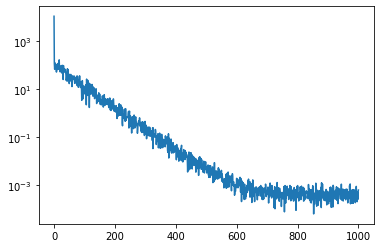

In [111]:
plt.plot(conv_sgd)
plt.yscale("log")

In [126]:
def coordinate_wise_grad(A, y, x, idx):
    return A[:, idx].t() @ (A @ x - b)

def sampler(n, block_size):
    return torch.randint(0, n, (block_size,))


max_iter = n_epoch 
x_rcd = x.clone()

def rcd(x, alpha, max_iter, block_size=1):
    st = time.time()
    conv_rcd = []
    conv_rcd.append(l2_loss(b, f(A, x)))
    for i in range(max_iter):
        current_shuffling = torch.randint(0, x.shape[0], (x.shape[0],))
        for idx in current_shuffling:
            grad_i = coordinate_wise_grad(A, b, x, idx)
            x[idx] = x[idx] - alpha * grad_i
            conv_rcd.append(l2_loss(b, f(A, x)))
    print("Time RCD = {}".format(time.time() - st))
    return x, conv_rcd

In [127]:
alpha = 1e-4
_, conv_rcd = rcd(x_rcd, alpha, 10*max_iter)

Time RCD = 0.15591096878051758


(array([1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 <a list of 8 Text yticklabel objects>)

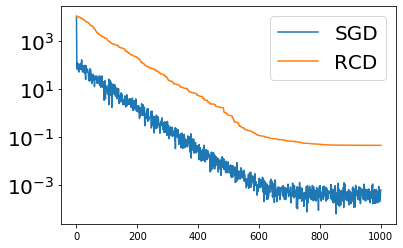

In [128]:
plt.plot(conv_sgd, label="SGD")
plt.plot(conv_rcd, label="RCD")
plt.yscale("log")
plt.legend(fontsize=20)
plt.yticks(fontsize=20)

In [129]:
def sag(alpha, x0, max_iter, num_samples):
    x = x0.clone()
#     full_grad = A.t() @ (A @ x - b)
    g = torch.zeros((num_samples, x.shape[0]))
    for i in range(num_samples):
        g[i, :] = A[i, :].t() * (A[i, :] @ x - b[i])
    d = torch.mean(g, dim=0)
    conv_sag = []
    conv_sag.append(l2_loss(b, f(A, x)))
    st = time.time()
    for i in range(max_iter):
        index = torch.randint(0, num_samples, (1,))
        update_gradi = A[index, :].t() * (A[index, :] @ x - b[index])
        d = d - g[index,:].view(-1) / num_samples + update_gradi.view(-1) / num_samples
        g[index, :] = update_gradi.t()
#         d = torch.mean(g, dim=0)
        x = x - alpha * d
        conv_sag.append(l2_loss(b, f(A, x)))
    print('Time SAG = {}'.format(time.time() - st))
    return conv_sag

In [134]:
x_sag = x.clone()
alpha = 1e-3
conv_sag = sag(alpha, x_sag, 20000, A.shape[0])

Time SAG = 4.7486090660095215


(array([1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 <a list of 8 Text yticklabel objects>)

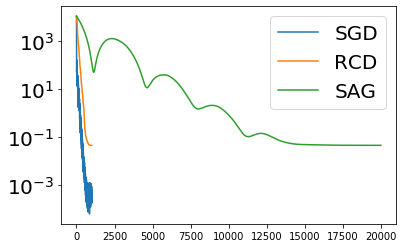

In [135]:
plt.plot(conv_sgd, label="SGD")
plt.plot(conv_rcd, label="RCD")
plt.plot(conv_sag, label="SAG")
plt.yscale("log")
plt.legend(fontsize=20)
plt.yticks(fontsize=20)

In [136]:
def saga(alpha, x0, max_iter, num_samples):
    x = x0.clone()
    g = torch.zeros((num_samples, x.shape[0]))
    for i in range(num_samples):
        g[i, :] = A[i, :].t() * (A[i, :] @ x - b[i])
    d = torch.mean(g, dim=0)
    conv_saga = []
    conv_saga.append(l2_loss(b, f(A, x)))
    st = time.time()
    for i in range(max_iter):
        index = torch.randint(0, num_samples, (1,))
        update_gradi = A[index[0], :] * (A[index[0], :] @ x - b[index[0]])
        h = d - g[index,:].view(-1) + update_gradi.view(-1)
        d = d - g[index,:].view(-1) / num_samples + update_gradi.view(-1) / num_samples
        g[index, :] = update_gradi.t()
        x = x - alpha * h
        conv_saga.append(l2_loss(b, f(A, x)))
    print('Time SAGA = {}'.format(time.time() - st))
    return conv_saga



In [137]:
x_saga = x.clone()
alpha = 1e-3
conv_saga = saga(alpha, x_saga, 20000, A.shape[0])

Time SAGA = 3.9625041484832764


(array([1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 <a list of 8 Text yticklabel objects>)

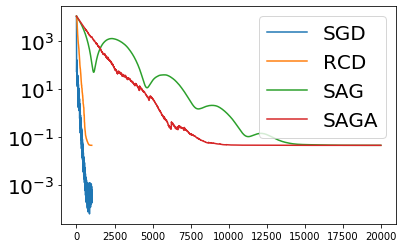

In [138]:
plt.plot(conv_sgd, label="SGD")
plt.plot(conv_rcd, label="RCD")
plt.plot(conv_sag, label="SAG")
plt.plot(conv_saga, label="SAGA")
plt.yscale("log")
plt.legend(fontsize=20)
plt.yticks(fontsize=20)

##  Насколько эти методы применимы на практике?

- Применение этих методов напрямую для обучения глубоких сетей не помогает
- Причины
    - Многие слои нарушают предположение о представлении целевой функции как суммы
    - Значение градиента перед новой эпохой утсаревпет слишком сильно в проессе оптимизации внутри эпохи и не порогает уменьшить дисперсию
- Подробности и анализ см в работе [On the Ineffectiveness of Variance Reduced
Optimization for Deep Learning by Aaron Defazio & Leon Bottou](https://papers.nips.cc/paper/8452-on-the-ineffectiveness-of-variance-reduced-optimization-for-deep-learning.pdf)